In [5]:
import numpy as np
import gc
import os
import sys
sys.path.append("../")
sys.path.append("../03_experimental_data_chemical_shifts/")
import matplotlib.pyplot as plt

import SRT_optimization as srt
import handle_BMBR as BMBR
from matplotlib.backends.backend_pdf import PdfPages

import matplotlib.gridspec as gridspec

gc.collect()

624

In [2]:
BMBR_path="../../../OLD_CORY/sds_vs_peptide/BMRB_experimental_data/"
PPSpred_path="../04_predict_2str_PSSpred/data/"

experiments=BMBR.load_BMBR(BMBR_path)
secondary_structure=BMBR.load_PSSpred_structure(PPSpred_path)

4697 .


In [3]:
partially_disordered={}
entries=['51418','19284','26823','25077','15254']
for entry in entries:
    partially_disordered[entry]={}
    partially_disordered[entry]["full"]={}
    partially_disordered[entry]["disordered"]={}
    for condition in experiments[entry]['T2measur']:
        for measurament,data in experiments[entry]['T2measur'][condition].items():
            #print(entry,measurament,data['results'])
            field=data['field']
            try:
                effTimes=[]
                for R2 in data['results']['R2']:
                    effTimes.append(srt.find_tau_from_R2_np_poly1d(float(field),float(R2)))
                partially_disordered[entry]['full'][field]={}
                partially_disordered[entry]['full'][field]['residues']=data['results']["atomID"]
                partially_disordered[entry]['full'][field]['residuesReal']=data['results']["atomIDreal"]
                partially_disordered[entry]['full'][field]['effTimes']=np.array(effTimes)*10**9
            except:
                pass
        
partially_disordered['EN2']={}
partially_disordered['EN2']['full']={}
partially_disordered['EN2']['full']['800']={}
partially_disordered['EN2']['full']['800']['residues']=[]
partially_disordered['EN2']['full']['800']['effTimes']=[]
with open('EN2_R2_exp.dat','r') as file:
    for line in file:
        partially_disordered['EN2']['full']['800']['residues'].append(int(line.split()[0]))
        partially_disordered['EN2']['full']['800']['effTimes'].append(srt.find_tau_from_R2_np_poly1d(800,float(line.split()[1]))*10**9)
partially_disordered['EN2']['full']['800']['residuesReal']=partially_disordered['EN2']['full']['800']['residues']        
partially_disordered['tonB']={}
partially_disordered['tonB']['full']={}
partially_disordered['tonB']['full'][850]={}
partially_disordered['tonB']['full'][850]['residues']=[]
partially_disordered['tonB']['full'][850]['effTimes']=[]
with open('tonB_experimentalDATAT1T2NOE.dat','r') as file:
    for line in file:
        if '%' in line:
            pass
        elif not len(line.split())==7:
            pass
        elif not line.split()[3]=='nan':
            partially_disordered['tonB']['full'][850]['residues'].append(int(line.split()[0]))
            partially_disordered['tonB']['full'][850]['effTimes'].append(srt.find_tau_from_R2_np_poly1d(850,1/float(line.split()[3]))*10**9)        
            
partially_disordered['tonB']['full'][850]['residuesReal']=partially_disordered['tonB']['full'][850]['residues']
partially_disordered['25077']['full'][599.427]['residuesReal']=list(np.array(partially_disordered['25077']['full'][599.427]['residuesReal'])+493)
partially_disordered['15254']['full'][720]['residuesReal']=list(np.array(partially_disordered['15254']['full'][720]['residues'])+105)

In [4]:
#foramt: ID: [structured, disordered, magnetic field]
entries={'EN2':[[(24,30),(57,-5)],[(0,19),(34,52)],'800',[(15+194,27+194),(33+194,43+194),(47+194,59+194)],[],'EN2'],
        '15254':[[(26,-1)],[(8,23)],720,[(154,158),(179,183)],[(163,167),(189,192),(193,198),(199,205),
                                                                (207,214),(219,223)],'Pr-SH3'],
         '26823':[[(41,51)],[(0,34),(65,-1)],850,[(321,331)],[],'TDP-43'],
         'tonB':[[(52,-2)],[(0,51)],850,[(184,189),(195,208),(213,217),(248,264)],
                 [(222,231),(235,245),(271,280)],'TonB'],
         '19284':[[(0,68)],[(68,-1)],600,[(8,14),(16,28),(33,43),(48,64)],[(30,32),(67,70),(75,79)],'δ subunit'],
         '25077':[[(8,78)],[(85,-1)],599.427,[(536,538),(551,554),(578,588),(589,592)],
                  [(516,521),(530,534),(543,548),(563,570),(572,573),(596,603)],'PDZ-linker'],
         '51418':[[(5,82),(138,-1)],[(83,137)],800,[(60,76),(80,84),(96,101),(106,116),
                                                              (121,140),(144,163),(348,365),(368,373),
                                                              (389,394),(399,409),(414,432),(436,456)],
          [],'BRD4']}



#'51418':[[(5,82),(138,-1)],[(83,128),(129,137)],800,[(60,76),(80,84),(96,101),(106,116),
  #                                                            (121,140),(144,163),(348,365),(368,373),
  #                                                            (389,394),(399,409),(414,432),(436,456)],



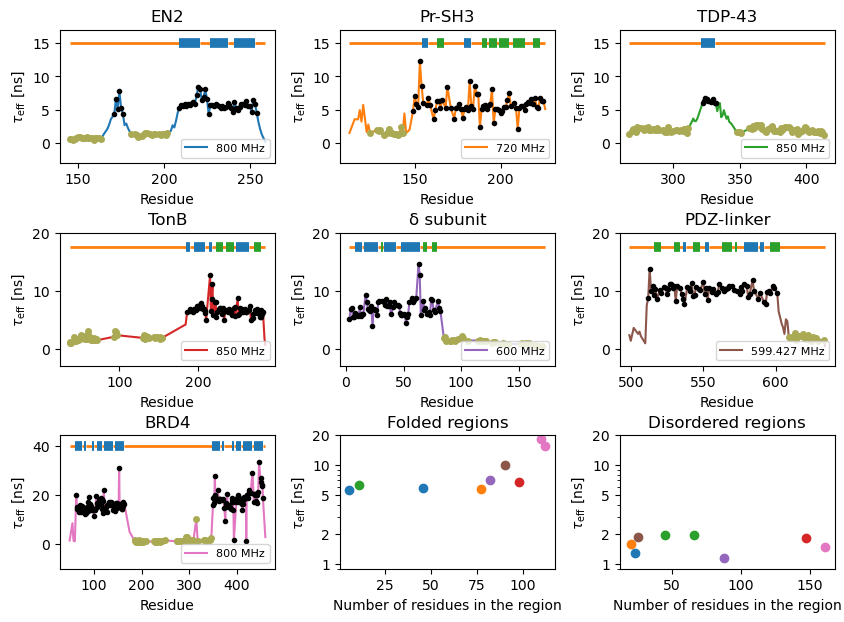

In [22]:
fig = plt.figure(figsize=(10,7))
axs={}
outer = gridspec.GridSpec(3,3, wspace=0.3, hspace=0.52)
for i in range(3):
    for j in range(3):
        axs[i,j]= plt.Subplot(fig, outer[i*3+j])
        fig.add_subplot(axs[i,j])
        axs[i,j].set_xlabel('Residue')
        axs[i,j].set_ylabel(r'$\tau_{\mathrm{eff}}$ [ns]')
        
for i,entry in enumerate(entries):
    field=entries[entry][2]
    low=min(partially_disordered[entry]['full'][field]['effTimes'])
    high=max(partially_disordered[entry]['full'][field]['effTimes'])
    diff=high-low
    if not len(partially_disordered[entry]['full'][field]['residuesReal'])>0:
        axs[i//3,i%3].plot(partially_disordered[entry]['full'][field]['residues'],partially_disordered[entry]['full'][field]['effTimes'],label=str(field)+' MHz',c='C'+str(i))
        for limits in entries[entry][0]:
            beg=limits[0]
            end=limits[1]
            axs[i//3,i%3].plot(partially_disordered[entry]['full'][field]['residues'][beg:end],partially_disordered[entry]['full'][field]['effTimes'][beg:end],'.',c='black')

        for limits in entries[entry][1]:
            beg=limits[0]
            end=limits[1]
            axs[i//3,i%3].plot(partially_disordered[entry]['full'][field]['residues'][beg:end],partially_disordered[entry]['full'][field]['effTimes'][beg:end],'.',markersize=8,c='#aaaa55')
    else:
        axs[i//3,i%3].plot(partially_disordered[entry]['full'][field]['residuesReal'],partially_disordered[entry]['full'][field]['effTimes'],label=str(field)+' MHz',c='C'+str(i))
        for limits in entries[entry][0]:
            beg=limits[0]
            end=limits[1]
            axs[i//3,i%3].plot(partially_disordered[entry]['full'][field]['residuesReal'][beg:end],partially_disordered[entry]['full'][field]['effTimes'][beg:end],'.',c='black')

        for limits in entries[entry][1]:
            beg=limits[0]
            end=limits[1]
            axs[i//3,i%3].plot(partially_disordered[entry]['full'][field]['residuesReal'][beg:end],partially_disordered[entry]['full'][field]['effTimes'][beg:end],'.',markersize=8,c='#aaaa55')

    try:
        if  i//3 == 2:
            start=partially_disordered[entry]['full'][field]['residuesReal'][0]
            for helix in entries[entry][3]:
                if helix[0]>start:
                    xs=[start,helix[0]]
                    axs[i//3,i%3].plot(xs,[high+diff/5]*2,'-',linewidth=2,c="C1",solid_capstyle='butt')
                start=helix[1]
                xs=[helix[0],helix[1]]
                axs[i//3,i%3].plot(xs,[high+diff/5]*2,'-',linewidth=7,c="C0",solid_capstyle='butt')
            if start<partially_disordered[entry]['full'][field]['residuesReal'][-1]:
                xs=[start,partially_disordered[entry]['full'][field]['residuesReal'][-1]]
                axs[i//3,i%3].plot(xs,[high+diff/5]*2,'-',linewidth=2,c="C1",solid_capstyle='butt')
            for helix in entries[entry][4]:
                xs=[helix[0],helix[1]]
                axs[i//3,i%3].plot(xs,[high+diff/5]*2,'-',linewidth=7,c="C2",solid_capstyle='butt')
        elif i//3 == 0:
            start=partially_disordered[entry]['full'][field]['residuesReal'][0]
            for helix in entries[entry][3]:
                if helix[0]>start:
                    xs=[start,helix[0]]
                    axs[i//3,i%3].plot(xs,[15]*2,'-',linewidth=2,c="C1",solid_capstyle='butt')
                start=helix[1]
                xs=[helix[0],helix[1]]
                axs[i//3,i%3].plot(xs,[15]*2,'-',linewidth=7,c="C0",solid_capstyle='butt')
            if start<partially_disordered[entry]['full'][field]['residuesReal'][-1]:
                xs=[start,partially_disordered[entry]['full'][field]['residuesReal'][-1]]
                axs[i//3,i%3].plot(xs,[15]*2,'-',linewidth=2,c="C1",solid_capstyle='butt')
            for helix in entries[entry][4]:
                xs=[helix[0],helix[1]]
                axs[i//3,i%3].plot(xs,[15]*2,'-',linewidth=7,c="C2",solid_capstyle='butt')
        elif i//3 == 1:
            start=partially_disordered[entry]['full'][field]['residuesReal'][0]
            for helix in entries[entry][3]:
                if helix[0]>start:
                    xs=[start,helix[0]]
                    axs[i//3,i%3].plot(xs,[17.5]*2,'-',linewidth=2,c="C1",solid_capstyle='butt')
                start=helix[1]
                xs=[helix[0],helix[1]]
                axs[i//3,i%3].plot(xs,[17.5]*2,'-',linewidth=7,c="C0",solid_capstyle='butt')
            if start<partially_disordered[entry]['full'][field]['residuesReal'][-1]:
                xs=[start,partially_disordered[entry]['full'][field]['residuesReal'][-1]]
                axs[i//3,i%3].plot(xs,[17.5]*2,'-',linewidth=2,c="C1",solid_capstyle='butt')
            for helix in entries[entry][4]:
                xs=[helix[0],helix[1]]
                axs[i//3,i%3].plot(xs,[17.5]*2,'-',linewidth=7,c="C2",solid_capstyle='butt')
    except Exception as e:
        pass
    axs[i//3,i%3].legend(prop={'size':8},loc=4)
    
    
    axs[i//3,i%3].set_ylim(-3,17)
    if i//3 ==1:
        axs[i//3,i%3].set_ylim(-3,20)
    if i//3 ==2:
        axs[i//3,i%3].set_ylim(low-diff/3,high+diff/3)
    if entry=='EN2':
        axs[i//3,i%3].legend(loc=4,prop={'size':8})
    axs[i//3,i%3].set_title(entries[entry][5])
    
    
    data=entries[entry]
    structured=[]
    disordered=[]
    field=data[2]
    structured_length=0
    disordered_length=0
    for indexes in data[0]:
        structured+=list(partially_disordered[entry]['full'][field]['effTimes'][indexes[0]:indexes[1]])
       
        structured_length+=partially_disordered[entry]['full'][field]['residues'][indexes[1]]-partially_disordered[entry]['full'][field]['residues'][indexes[0]]
        axs[2,1].plot(partially_disordered[entry]['full'][field]['residues'][indexes[1]]-partially_disordered[entry]['full'][field]['residues'][indexes[0]],np.mean(list(partially_disordered[entry]['full'][field]['effTimes'][indexes[0]:indexes[1]])),'o',c='C'+str(i))
    
    for indexes in data[1]:
        disordered+=list(partially_disordered[entry]['full'][field]['effTimes'][indexes[0]:indexes[1]])
        disordered_length+=partially_disordered[entry]['full'][field]['residues'][indexes[1]]-partially_disordered[entry]['full'][field]['residues'][indexes[0]]
        axs[2,2].plot(partially_disordered[entry]['full'][field]['residues'][indexes[1]]-partially_disordered[entry]['full'][field]['residues'][indexes[0]],np.mean(list(partially_disordered[entry]['full'][field]['effTimes'][indexes[0]:indexes[1]])),'o',c='C'+str(i))
    
    #print(np.mean(structured),np.mean(disordered))
    
axs[2,1].set_title("Folded regions")
axs[2,2].set_title("Disordered regions")


axs[2,1].set_xlabel('Number of residues in the region')
axs[2,2].set_xlabel('Number of residues in the region')

axs[2,1].set_ylim(0.9,20)
axs[2,2].set_ylim(0.9,20)

axs[2,1].set_yscale('log')
axs[2,2].set_yscale('log')

axs[2,1].set_yticks([1,2,5,10,20],[1,2,5,10,20])
axs[2,2].set_yticks([1,2,5,10,20],[1,2,5,10,20])


plt.savefig('suitable_partially_disordered_big_field.pdf')

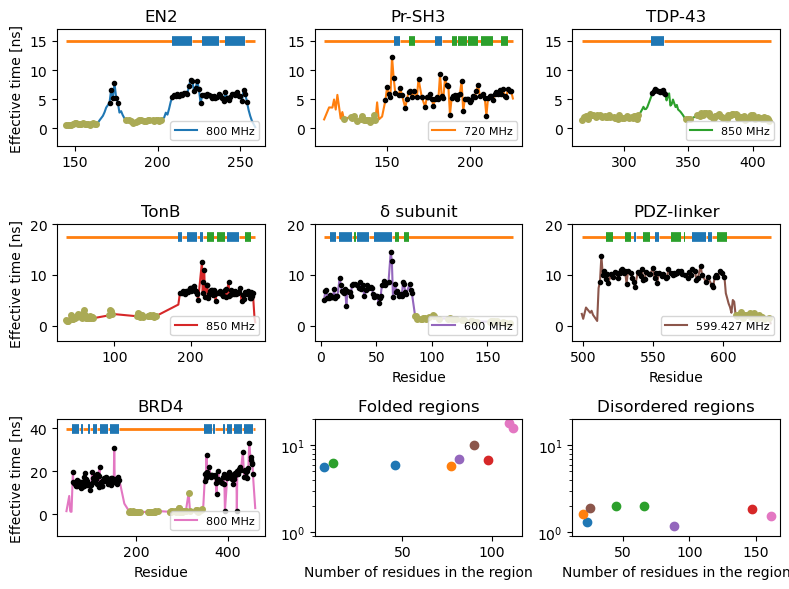

In [14]:
plt.rcParams["figure.autolayout"] = True
fig, axs = plt.subplots(3,3,figsize=(8,6))
for i,entry in enumerate(entries):
    field=entries[entry][2]
    low=min(partially_disordered[entry]['full'][field]['effTimes'])
    high=max(partially_disordered[entry]['full'][field]['effTimes'])
    diff=high-low
    if not len(partially_disordered[entry]['full'][field]['residuesReal'])>0:
        axs[i//3,i%3].plot(partially_disordered[entry]['full'][field]['residues'],partially_disordered[entry]['full'][field]['effTimes'],label=str(field)+' MHz',c='C'+str(i))
        for limits in entries[entry][0]:
            beg=limits[0]
            end=limits[1]
            axs[i//3,i%3].plot(partially_disordered[entry]['full'][field]['residues'][beg:end],partially_disordered[entry]['full'][field]['effTimes'][beg:end],'.',c='black')

        for limits in entries[entry][1]:
            beg=limits[0]
            end=limits[1]
            axs[i//3,i%3].plot(partially_disordered[entry]['full'][field]['residues'][beg:end],partially_disordered[entry]['full'][field]['effTimes'][beg:end],'.',markersize=8,c='#aaaa55')
    else:
        axs[i//3,i%3].plot(partially_disordered[entry]['full'][field]['residuesReal'],partially_disordered[entry]['full'][field]['effTimes'],label=str(field)+' MHz',c='C'+str(i))
        for limits in entries[entry][0]:
            beg=limits[0]
            end=limits[1]
            axs[i//3,i%3].plot(partially_disordered[entry]['full'][field]['residuesReal'][beg:end],partially_disordered[entry]['full'][field]['effTimes'][beg:end],'.',c='black')

        for limits in entries[entry][1]:
            beg=limits[0]
            end=limits[1]
            axs[i//3,i%3].plot(partially_disordered[entry]['full'][field]['residuesReal'][beg:end],partially_disordered[entry]['full'][field]['effTimes'][beg:end],'.',markersize=8,c='#aaaa55')

    try:
        if  i//3 == 2:
            start=partially_disordered[entry]['full'][field]['residuesReal'][0]
            for helix in entries[entry][3]:
                if helix[0]>start:
                    xs=[start,helix[0]]
                    axs[i//3,i%3].plot(xs,[high+diff/5]*2,'-',linewidth=2,c="C1",solid_capstyle='butt')
                start=helix[1]
                xs=[helix[0],helix[1]]
                axs[i//3,i%3].plot(xs,[high+diff/5]*2,'-',linewidth=7,c="C0",solid_capstyle='butt')
            if start<partially_disordered[entry]['full'][field]['residuesReal'][-1]:
                xs=[start,partially_disordered[entry]['full'][field]['residuesReal'][-1]]
                axs[i//3,i%3].plot(xs,[high+diff/5]*2,'-',linewidth=2,c="C1",solid_capstyle='butt')
            for helix in entries[entry][4]:
                xs=[helix[0],helix[1]]
                axs[i//3,i%3].plot(xs,[high+diff/5]*2,'-',linewidth=7,c="C2",solid_capstyle='butt')
        elif i//3 == 0:
            start=partially_disordered[entry]['full'][field]['residuesReal'][0]
            for helix in entries[entry][3]:
                if helix[0]>start:
                    xs=[start,helix[0]]
                    axs[i//3,i%3].plot(xs,[15]*2,'-',linewidth=2,c="C1",solid_capstyle='butt')
                start=helix[1]
                xs=[helix[0],helix[1]]
                axs[i//3,i%3].plot(xs,[15]*2,'-',linewidth=7,c="C0",solid_capstyle='butt')
            if start<partially_disordered[entry]['full'][field]['residuesReal'][-1]:
                xs=[start,partially_disordered[entry]['full'][field]['residuesReal'][-1]]
                axs[i//3,i%3].plot(xs,[15]*2,'-',linewidth=2,c="C1",solid_capstyle='butt')
            for helix in entries[entry][4]:
                xs=[helix[0],helix[1]]
                axs[i//3,i%3].plot(xs,[15]*2,'-',linewidth=7,c="C2",solid_capstyle='butt')
        elif i//3 == 1:
            start=partially_disordered[entry]['full'][field]['residuesReal'][0]
            for helix in entries[entry][3]:
                if helix[0]>start:
                    xs=[start,helix[0]]
                    axs[i//3,i%3].plot(xs,[17.5]*2,'-',linewidth=2,c="C1",solid_capstyle='butt')
                start=helix[1]
                xs=[helix[0],helix[1]]
                axs[i//3,i%3].plot(xs,[17.5]*2,'-',linewidth=7,c="C0",solid_capstyle='butt')
            if start<partially_disordered[entry]['full'][field]['residuesReal'][-1]:
                xs=[start,partially_disordered[entry]['full'][field]['residuesReal'][-1]]
                axs[i//3,i%3].plot(xs,[17.5]*2,'-',linewidth=2,c="C1",solid_capstyle='butt')
            for helix in entries[entry][4]:
                xs=[helix[0],helix[1]]
                axs[i//3,i%3].plot(xs,[17.5]*2,'-',linewidth=7,c="C2",solid_capstyle='butt')
    except Exception as e:
        pass
    axs[i//3,i%3].legend(prop={'size':8},loc=4)
    
    
    axs[i//3,i%3].set_ylim(-3,17)
    if i//3 ==1:
        axs[i//3,i%3].set_ylim(-3,20)
    if i//3 ==2:
        axs[i//3,i%3].set_ylim(low-diff/3,high+diff/3)
    if entry=='EN2':
        axs[i//3,i%3].legend(loc=4,prop={'size':8})
    axs[i//3,i%3].set_title(entries[entry][5])
    
    
    data=entries[entry]
    structured=[]
    disordered=[]
    field=data[2]
    structured_length=0
    disordered_length=0
    for indexes in data[0]:
        structured+=list(partially_disordered[entry]['full'][field]['effTimes'][indexes[0]:indexes[1]])
       
        structured_length+=partially_disordered[entry]['full'][field]['residues'][indexes[1]]-partially_disordered[entry]['full'][field]['residues'][indexes[0]]
        axs[2,1].plot(partially_disordered[entry]['full'][field]['residues'][indexes[1]]-partially_disordered[entry]['full'][field]['residues'][indexes[0]],np.mean(list(partially_disordered[entry]['full'][field]['effTimes'][indexes[0]:indexes[1]])),'o',c='C'+str(i))
    
    for indexes in data[1]:
        disordered+=list(partially_disordered[entry]['full'][field]['effTimes'][indexes[0]:indexes[1]])
        disordered_length+=partially_disordered[entry]['full'][field]['residues'][indexes[1]]-partially_disordered[entry]['full'][field]['residues'][indexes[0]]
        axs[2,2].plot(partially_disordered[entry]['full'][field]['residues'][indexes[1]]-partially_disordered[entry]['full'][field]['residues'][indexes[0]],np.mean(list(partially_disordered[entry]['full'][field]['effTimes'][indexes[0]:indexes[1]])),'o',c='C'+str(i))
    
    #print(np.mean(structured),np.mean(disordered))
    
axs[2,1].set_title("Folded regions")
axs[2,2].set_title("Disordered regions")

axs[0,0].set_ylabel('Effective time [ns]')
axs[1,0].set_ylabel('Effective time [ns]')
axs[2,0].set_ylabel('Effective time [ns]')

axs[2,0].set_xlabel('Residue')
axs[1,1].set_xlabel('Residue')
axs[1,2].set_xlabel('Residue')

axs[2,1].set_xlabel('Number of residues in the region')
axs[2,2].set_xlabel('Number of residues in the region')

axs[2,1].set_ylim(0.9,20)
axs[2,2].set_ylim(0.9,20)

axs[2,1].set_yscale('log')
axs[2,2].set_yscale('log')

plt.savefig('suitable_partially_disordered_big_field.pdf')

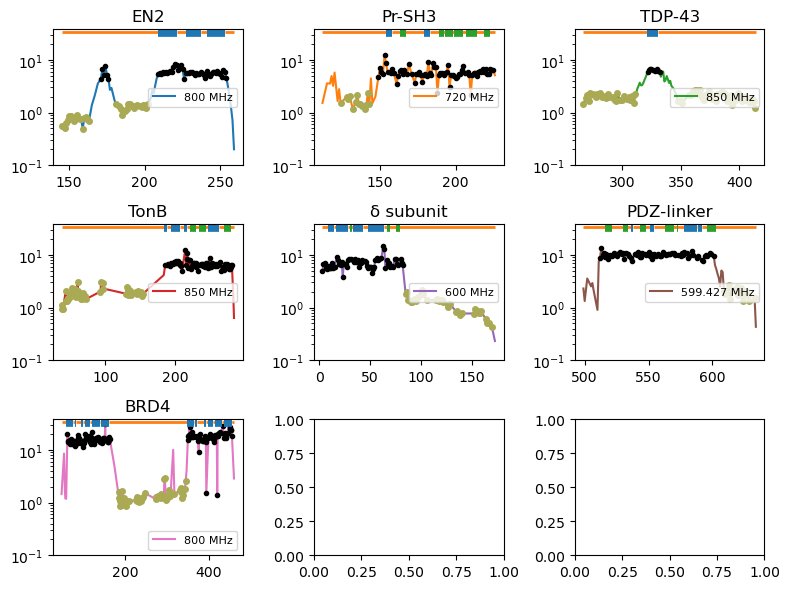

In [7]:
plt.rcParams["figure.autolayout"] = True
fig, axs = plt.subplots(3,3,figsize=(8,6))
for i,entry in enumerate(entries):
    field=entries[entry][2]
    if not len(partially_disordered[entry]['full'][field]['residuesReal'])>0:
        axs[i//3,i%3].plot(partially_disordered[entry]['full'][field]['residues'],partially_disordered[entry]['full'][field]['effTimes'],label=str(field)+' MHz',c='C'+str(i))
        for limits in entries[entry][0]:
            beg=limits[0]
            end=limits[1]
            axs[i//3,i%3].plot(partially_disordered[entry]['full'][field]['residues'][beg:end],partially_disordered[entry]['full'][field]['effTimes'][beg:end],'.',c='black')

        for limits in entries[entry][1]:
            beg=limits[0]
            end=limits[1]
            axs[i//3,i%3].plot(partially_disordered[entry]['full'][field]['residues'][beg:end],partially_disordered[entry]['full'][field]['effTimes'][beg:end],'.',markersize=8,c='#aaaa55')
    else:
        axs[i//3,i%3].plot(partially_disordered[entry]['full'][field]['residuesReal'],partially_disordered[entry]['full'][field]['effTimes'],label=str(field)+' MHz',c='C'+str(i))
        for limits in entries[entry][0]:
            beg=limits[0]
            end=limits[1]
            axs[i//3,i%3].plot(partially_disordered[entry]['full'][field]['residuesReal'][beg:end],partially_disordered[entry]['full'][field]['effTimes'][beg:end],'.',c='black')

        for limits in entries[entry][1]:
            beg=limits[0]
            end=limits[1]
            axs[i//3,i%3].plot(partially_disordered[entry]['full'][field]['residuesReal'][beg:end],partially_disordered[entry]['full'][field]['effTimes'][beg:end],'.',markersize=8,c='#aaaa55')

    try:
        start=partially_disordered[entry]['full'][field]['residuesReal'][0]
        for helix in entries[entry][3]:
            if helix[0]>start:
                xs=[start,helix[0]]
                axs[i//3,i%3].plot(xs,[34]*2,'-',linewidth=2,c="C1",solid_capstyle='butt')
            start=helix[1]
            xs=[helix[0],helix[1]]
            axs[i//3,i%3].plot(xs,[34]*2,'-',linewidth=7,c="C0",solid_capstyle='butt')
        if start<partially_disordered[entry]['full'][field]['residuesReal'][-1]:
            xs=[start,partially_disordered[entry]['full'][field]['residuesReal'][-1]]
            axs[i//3,i%3].plot(xs,[34]*2,'-',linewidth=2,c="C1",solid_capstyle='butt')
        for helix in entries[entry][4]:
            xs=[helix[0],helix[1]]
            axs[i//3,i%3].plot(xs,[34]*2,'-',linewidth=7,c="C2",solid_capstyle='butt')
    except Exception as e:
        pass
    axs[i//3,i%3].legend(prop={'size':8},loc=5)
    low=min(partially_disordered[entry]['full'][field]['effTimes'])
    high=max(partially_disordered[entry]['full'][field]['effTimes'])
    diff=high-low
    axs[i//3,i%3].set_ylim(low-diff/3,high+diff/8)
    axs[i//3,i%3].set_ylim(-4,38)
    if entry=='51418':
        axs[i//3,i%3].legend(loc=4,prop={'size':8})
    axs[i//3,i%3].set_title(entries[entry][5])
    axs[i//3,i%3].set_ylim(0.1,38)
    axs[i//3,i%3].set_yscale('log')
plt.savefig('suitable_partially_disordered_big_field3.png')

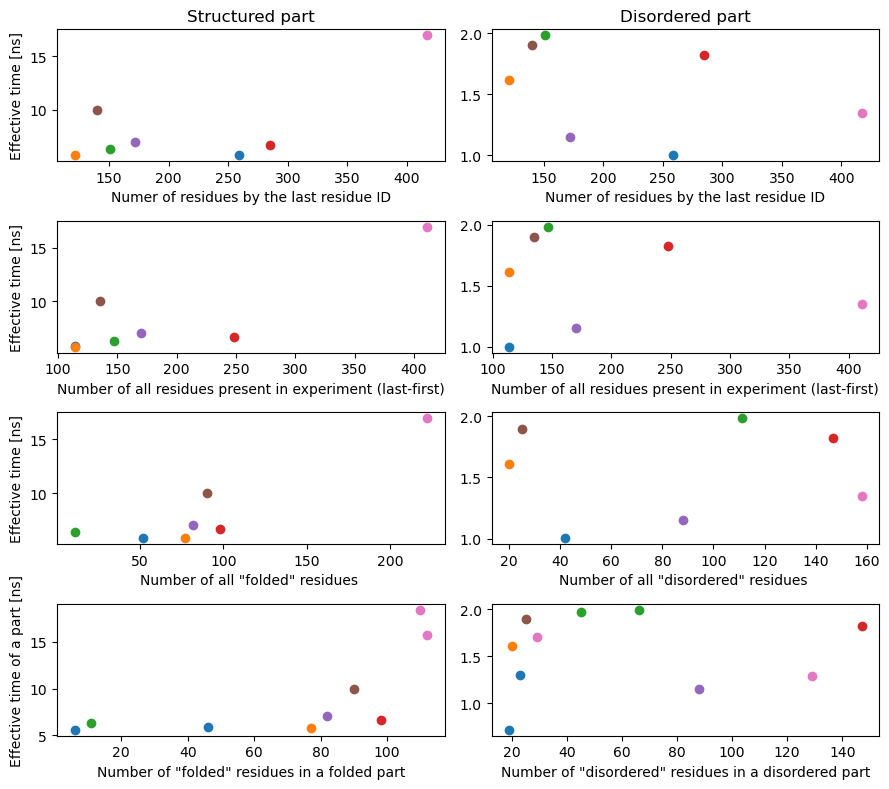

In [9]:
plt.rcParams['figure.autolayout']=True
fig, axs = plt.subplots(4,2,figsize=(9,8),sharey=False)
i=0
for entry,data in entries.items():
    structured=[]
    disordered=[]
    field=data[2]
    structured_length=0
    disordered_length=0
    for indexes in data[0]:
        structured+=list(partially_disordered[entry]['full'][field]['effTimes'][indexes[0]:indexes[1]])
       
        structured_length+=partially_disordered[entry]['full'][field]['residues'][indexes[1]]-partially_disordered[entry]['full'][field]['residues'][indexes[0]]
        axs[3,0].plot(partially_disordered[entry]['full'][field]['residues'][indexes[1]]-partially_disordered[entry]['full'][field]['residues'][indexes[0]],np.mean(list(partially_disordered[entry]['full'][field]['effTimes'][indexes[0]:indexes[1]])),'o',c='C'+str(i))
    
    for indexes in data[1]:
        disordered+=list(partially_disordered[entry]['full'][field]['effTimes'][indexes[0]:indexes[1]])
        disordered_length+=partially_disordered[entry]['full'][field]['residues'][indexes[1]]-partially_disordered[entry]['full'][field]['residues'][indexes[0]]
        axs[3,1].plot(partially_disordered[entry]['full'][field]['residues'][indexes[1]]-partially_disordered[entry]['full'][field]['residues'][indexes[0]],np.mean(list(partially_disordered[entry]['full'][field]['effTimes'][indexes[0]:indexes[1]])),'o',c='C'+str(i))
    
    #print(np.mean(structured),np.mean(disordered))
    axs[0,0].plot(partially_disordered[entry]['full'][field]['residues'][-1],np.mean(structured),'o')
    axs[0,1].plot(partially_disordered[entry]['full'][field]['residues'][-1],np.mean(disordered),'o')
    axs[1,0].plot(partially_disordered[entry]['full'][field]['residues'][-1]-partially_disordered[entry]['full'][field]['residues'][0],np.mean(structured),'o')
    axs[1,1].plot(partially_disordered[entry]['full'][field]['residues'][-1]-partially_disordered[entry]['full'][field]['residues'][0],np.mean(disordered),'o')
    axs[2,0].plot(structured_length,np.mean(structured),'o')
    axs[2,1].plot(disordered_length,np.mean(disordered),'o')
    
    i+=1
axs[0,0].set_title('Structured part')
axs[0,1].set_title('Disordered part')


axs[0,0].set_xlabel('Numer of residues by the last residue ID')
axs[0,1].set_xlabel('Numer of residues by the last residue ID')

axs[0,0].set_ylabel('Effective time [ns]')
axs[1,0].set_ylabel('Effective time [ns]')
axs[2,0].set_ylabel('Effective time [ns]')
axs[3,0].set_ylabel('Effective time of a part [ns]')                    

axs[1,0].set_xlabel('Number of all residues present in experiment (last-first)')
axs[1,1].set_xlabel('Number of all residues present in experiment (last-first)')

axs[2,0].set_xlabel('Number of all "folded" residues ')
axs[3,0].set_xlabel('Number of "folded" residues in a folded part')

axs[2,1].set_xlabel('Number of all "disordered" residues ')
axs[3,1].set_xlabel('Number of "disordered" residues in a disordered part')
plt.savefig('partially_disordered_vs_size.png')

In [7]:
for entry,data in entries.items():
    field=data[2]
    print(partially_disordered[entry]['full'][field]['residues'][-1])

259
121
151
285
172
140
417
